In [1]:
%matplotlib inline

morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'

In [2]:
brightest_rband = -24.64
brightest_rband = -np.inf
def update_rest_rband(um_r_rest_old, r_rest_old, um_r_rest_new):
    """
    """
    mag_r_error = r_rest_old - um_r_rest_old
    new_rest_rband = um_r_rest_new + mag_r_error
    return np.where(new_rest_rband < brightest_rband, brightest_rband, new_rest_rband)

def update_observed_rband(r_obs_old, r_rest_old, r_rest_new):
    """
    """
    dr = r_obs_old - r_rest_old
    return r_rest_new + dr

def update_mag_i_obs(ri_rest_old, mag_i_rest_old, mag_i_obs_old, mag_r_rest_new):
    mag_i_rest_new = mag_r_rest_new - ri_rest_old
    kcorrection_i = mag_i_obs_old - mag_i_rest_old
    mag_i_obs_new = kcorrection_i + mag_i_rest_new
    return mag_i_rest_new, mag_i_obs_new


In [3]:
import os
dirname = "/Volumes/simulation_data_2018/protoDC2_v4"
basename = "v4.1.dust136.1substep.all.aph_reduced.hdf5"

fname = os.path.join(dirname, basename)

from astropy.table import Table
mock = Table.read(fname, path='data')

mock.rename_column('um_restframe_extincted_sdss_abs_magr', 'um_mag_r_rest')
mock.rename_column('um_restframe_extincted_sdss_gr', 'um_gr_rest')
mock.rename_column('um_restframe_extincted_sdss_ri', 'um_ri_rest')
mock['um_mag_g_rest'] = mock['um_gr_rest'] + mock['um_mag_r_rest']
mock['um_mag_i_rest'] = mock['um_mag_r_rest'] - mock['um_ri_rest']
print(mock.keys())

/Users/aphearin/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


['um_host_halo_mvir', 'um_obs_sm', 'um_obs_sfr', 'um_redshift', 'um_sfr_percentile', 'um_upid', 'um_mpeak', 'um_mag_r_rest', 'um_gr_rest', 'um_ri_rest', 'um_is_on_red_sequence_gr', 'um_is_on_red_sequence_ri', 'isCentral', 'redshift', 'hostHaloMass', 'mag_g_rest', 'mag_g_obs', 'mag_r_rest', 'mag_r_obs', 'mag_i_rest', 'mag_i_obs', 'mag_z_rest', 'mag_z_obs', 'um_mag_g_rest', 'um_mag_i_rest']


In [9]:
from cosmodc2.stellar_mass_remapping import lift_high_mass_mstar

new_mstar = lift_high_mass_mstar(
        mock['um_mpeak'], mock['um_obs_sm'], mock['um_upid'],  mock['redshift'])
mock['new_um_mstar'] = new_mstar
    
from cosmodc2.sdss_colors import magr_monte_carlo
mock['new_um_mag_r_rest'] = magr_monte_carlo(
    mock['new_um_mstar'], mock['um_upid'], mock['redshift'])
mock['new2_um_mag_r_rest'] = magr_monte_carlo(
    mock['new_um_mstar'], mock['um_upid'], mock['redshift'],
    gamma_boost_table=[0, -0.5, -0.5])


In [10]:
#  Estimate the new restframe Galacticus r-band
mock['new_mag_r_rest'] = update_rest_rband(
    mock['um_mag_r_rest'], mock['mag_r_rest'], mock['new_um_mag_r_rest'])
mock['new2_mag_r_rest'] = update_rest_rband(
    mock['um_mag_r_rest'], mock['mag_r_rest'], mock['new2_um_mag_r_rest'])

# #  Estimate the new observed Galacticus r-band
mock['new_mag_r_obs'] = update_observed_rband(
    mock['mag_r_obs'], mock['mag_r_rest'], mock['new_um_mag_r_rest'])
mock['new2_mag_r_obs'] = update_observed_rband(
    mock['mag_r_obs'], mock['mag_r_rest'], mock['new2_um_mag_r_rest'])

# #  Estimate the new observed UniverseMachine i-band
_mag_i_rest_new, _mag_i_obs_new = update_mag_i_obs(
    mock['um_ri_rest'], mock['um_mag_i_rest'], 
    mock['mag_i_obs'], mock['new_um_mag_r_rest'])
mock['new_mag_i_obs'] = _mag_i_obs_new
mock['new_mag_i_rest'] = _mag_i_rest_new

_mag_i_rest_new2, _mag_i_obs_new2 = update_mag_i_obs(
    mock['um_ri_rest'], mock['um_mag_i_rest'], 
    mock['mag_i_obs'], mock['new2_um_mag_r_rest'])
mock['new2_mag_i_obs'] = _mag_i_obs_new2
mock['new2_mag_i_rest'] = _mag_i_rest_new2

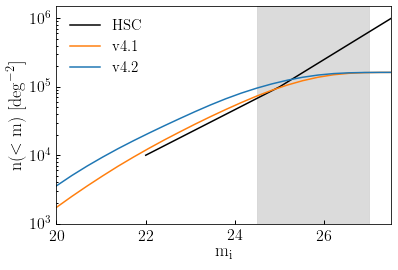

In [15]:
magarr = np.linspace(20, 30, 30)
magmasks = list((mock['mag_i_obs'] < m) for m in magarr)
counts = np.array([np.count_nonzero(mask) for mask in magmasks])
magmasks_new = list((mock['new_mag_i_obs'] < m) for m in magarr)
counts_new = np.array([np.count_nonzero(mask) for mask in magmasks_new])
magmasks_new2 = list((mock['new2_mag_i_obs'] < m) for m in magarr)
counts_new2 = np.array([np.count_nonzero(mask) for mask in magmasks_new2])

sky_area = 25.
fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
x1 = np.zeros(100) + 24.5
x2 = np.zeros(100) + 27
y = np.logspace(1, 10, 100)

__=ax.fill_betweenx(y, x1, x2, alpha=0.8, color='lightgray')

hsc_ordinates = [1e4, 1e5, 1e6]
hsc_abscissa = [22, 25, 27.5]
__=ax.plot(hsc_abscissa, hsc_ordinates, label=r'${\rm HSC}$', color='k')

__=ax.plot(magarr, counts/sky_area, label=r'${\rm v4.1}$', color=morange)
__=ax.plot(magarr, counts_new/sky_area, label=r'${\rm v4.2}$', color=mblue)
# __=ax.plot(magarr, counts_new2/sky_area, label=r'${\rm v4.2b}$', color=mblue)


xlabel = ax.set_xlabel(r'${\rm m_{i}}$')
ylabel = ax.set_ylabel(r'${\rm n(<m)\ [deg^{-2}]}$')
legend = ax.legend()
ylim = ax.set_ylim(1e3, 1.5e6)
xlim = ax.set_xlim(20, 27.5)

# figname = 'hsc_dndmag_pdc2_v4.png'
# fig.savefig(figname, bbox_extra_artists=[xlabel], bbox_inches='tight')

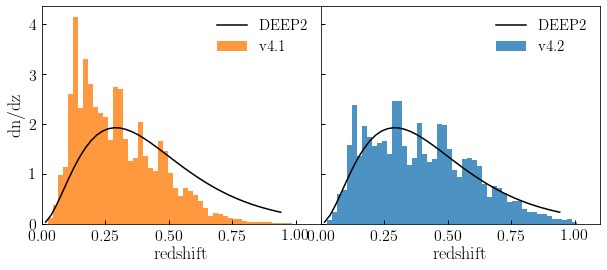

In [7]:
fname = "/Users/aphearin/Desktop/deep2_data.txt"
X = np.loadtxt(fname)
z = X[:, 0]
dndz = X[:, 1]

rmask_old = mock['mag_r_obs'] < 22
rmask_new = mock['new_mag_r_obs'] < 22
rmask_new2 = mock['new2_mag_r_obs'] < 22

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0)  

__=ax1.hist(mock['redshift'][rmask_old], normed=True, bins=50, alpha=0.8,
          label=r'${\rm v4.1}$', color=morange)
__=ax2.hist(mock['redshift'][rmask_new2], normed=True, bins=50, alpha=0.8, 
           label=r'${\rm v4.2}$', color=mblue)

__=ax1.plot(z, dndz, color='k', label=r'${\rm DEEP2}$')
__=ax2.plot(z, dndz, color='k', label=r'${\rm DEEP2}$')

legend = ax1.legend()
legend = ax2.legend()
xlabel = ax1.set_xlabel(r'${\rm redshift}$')
xlabel2 = ax2.set_xlabel(r'${\rm redshift}$')
ylabel = ax1.set_ylabel(r'${\rm dn/dz}$')

xlim = ax1.set_xlim(0.0, 1.1)

In [8]:
print("Brightest Galacticus galaxy = {0:.2f}".format(mock['mag_r_rest'].min()))
print("Brightest UMachine galaxy   = {0:.2f}".format(mock['um_mag_r_rest'].min()))
print("Brightest protoDC2 galaxy   = {0:.2f}".format(mock['new_mag_r_rest'].min()))
print("Brightest protoDC2b galaxy  = {0:.2f}".format(mock['new2_mag_r_rest'].min()))

Brightest Galacticus galaxy = -24.64
Brightest UMachine galaxy   = -25.17
Brightest protoDC2 galaxy   = -26.91
Brightest protoDC2b galaxy  = -26.93
